## SET UP

In [206]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Flatten, Bidirectional, Layer, Reshape, Input, Permute, Attention
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LayerNormalization, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Concatenate
from keras import regularizers
from keras.models import Model
import keras
from tensorflow.keras.optimizers import Adam
from keras import backend as K
%matplotlib inline

## DATA AGGREGATION

In [3]:
review_dtmtb = pd.read_csv('reviewData_dtmtb.csv')
review_dtdl = pd.read_csv('reviewData_dtdl.csv')
review_tbkts_pks = pd.read_csv('reviewData_tbkts_pks.csv')

NameError: name 'pd' is not defined

In [4]:
review_data = pd.concat([review_dtmtb, review_dtdl, review_tbkts_pks])

In [4]:
review_data.head()

,id,title,content,thank_count,customer_id,rating,created_at,customer_name,purchased_at
0,17206712,Cực kì hài lòng,"Mình vừa nhận được hàng, máy chạy tốt, pin sạc...",0,20468199,5,1658815564,NaN,NaN
1,17022830,Cực kì hài lòng,giao hàng đúng thời. điện thoại giao đúng mẫu....,3,21886251,5,1657513127,NaN,NaN
2,16990209,Cực kì hài lòng,giao hàng nhanh. đóng gói rất OK. mỗi tội tiếc...,5,14674088,5,1657279289,NaN,NaN
3,16618308,Cực kì hài lòng,Dùng siêu thích máy phiên bản 2022 và cùng năm...,1,14923716,5,1654645068,NaN,NaN
4,17056290,Cực kì hài lòng,cho tiki trading shop 5 sao!shop uy tín! giao ...,0,7966673,5,1657721825,NaN,NaN


In [5]:
review_data.value_counts('rating')

rating
5    92711
4    15936
1     7053
3     4882
2     2319
dtype: int64

In [6]:
review_data['content'].isna().sum()

45167

In [7]:
review_data.dropna(subset=['content'], inplace=True)

In [8]:
review_data['content'].isna().sum()

0

In [9]:
review_dtmtb.value_counts('title')

title
Cực kì hài lòng                                      16757
Hài lòng                                              2057
Rất không hài lòng                                     570
Bình thường                                            400
Không hài lòng                                         193
                                                     ...  
The perfect device to read on the go                     1
Thích                                                   1
Thông tin hàng không đúng                                1
Thất vọng về service giao 2h và hình thức đổi/hủy        1
10/10 về dịch vụ và sản phẩm                             1
Length: 480, dtype: int64

In [10]:
review_data.value_counts('rating')

rating
5    54361
4     9663
1     6990
3     4427
2     2293
dtype: int64

In [11]:
review_data['rating_class'] = review_data['rating'].apply(lambda x: 1 if x>3 else 0 if x==3 else -1)

In [12]:
review_data['rating_class'].value_counts()

 1    64024
-1     9283
 0     4427
Name: rating_class, dtype: int64

In [13]:
rating_data = review_data[['content','rating_class']]
rating_data = rating_data.rename(columns={'rating_class':"class"})
rating_data

,content,class
0,"Mình vừa nhận được hàng, máy chạy tốt, pin sạc...",1
1,giao hàng đúng thời. điện thoại giao đúng mẫu....,1
2,giao hàng nhanh. đóng gói rất OK. mỗi tội tiếc...,1
3,Dùng siêu thích máy phiên bản 2022 và cùng năm...,1
4,cho tiki trading shop 5 sao!shop uy tín! giao ...,1
...,...,...
41460,cực kỳ hài lòng,1
41461,"Sạc pin chỉ full 88%, nhờ shop tư vấn",-1
41462,nhìn rất ok.,1
41463,Giao hang nhah hang dung ok,1


In [14]:
data_train, data_test  = train_test_split(rating_data, test_size=0.2)

In [15]:
data_train.value_counts("class")

class
 1    51175
-1     7440
 0     3572
dtype: int64

In [16]:
data_test.value_counts("class")

class
 1    12849
-1     1843
 0      855
dtype: int64

In [19]:
data_train.to_csv('data_train.csv', index=False)
data_test.to_csv('data_test.csv', index=False)

## DATA PREPARATION

In [156]:
data_train = pd.read_csv('data_train.csv');
data_test = pd.read_csv('data_test.csv');

In [157]:

data_train_1 = data_train[data_train['class'] == 1]
data_train_0 = data_train[data_train['class'] == 0]
data_train_n1 = data_train[data_train['class'] == -1]

data_train_1 = resample(data_train_1, replace=False, n_samples=3000, random_state=1)
data_train_0 = resample(data_train_0, replace=False, n_samples=3000, random_state=2)
data_train_n1 = resample(data_train_n1, replace=False, n_samples=3000, random_state=3)

data_train = pd.concat([data_train_1, data_train_0, data_train_n1])

In [158]:
data_train.value_counts('class')

class
-1    3000
 0    3000
 1    3000
dtype: int64

In [159]:
labels = data_train.iloc[:,1].values
reviews = data_train.iloc[:,0].values
encoded_labels = []
for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label ==0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

encoded_labels = np.array(encoded_labels)

In [160]:
reviews_processed = []
unlabeld_processed = []
for review in reviews:
    review_cool_one = ''.join([char for char in review if char not in digits])
    reviews_processed.append(review_cool_one)
    
print(reviews[0])
print(reviews_processed[0])

Khá hài lòng
Khá hài lòng


In [161]:
word_reviews = []
all_words = []
for review in reviews_processed:
    review = ViTokenizer.tokenize(review.lower())
    word_reviews.append(review.split())

print(word_reviews[0])

['khá', 'hài_lòng']


In [130]:
EMBEDDING_DIM = 400 #how big is each word vector
MAX_VOCAB_SIZE = 10000 #how many unique words to use
MAX_SEQUENCE_LENGTH = 300 #max number of words in a comment to use

In [162]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE, lower = True, char_level = False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index

In [163]:
data = pad_sequences(sequences_train, maxlen = MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [164]:
sub_data = data[:2000]
sub_labels = labels[:2000]

In [165]:
sub_data.shape

(2000, 300)

In [166]:
print('Shape of X train and X validation tensor', data.shape)
print('Shape of label train and validation tensor', labels.shape)

Shape of X train and X validation tensor (9000, 300)
Shape of label train and validation tensor (9000, 3)


In [167]:
vocabulary_size = min(len(word_index) +1, MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Test data preparation

In [176]:
# data_test.value_counts('class')

data_test = pd.read_csv('data_test.csv');

In [168]:
# data_test_1 = data_test[data_test['class'] == 1]
# data_test_0 = data_test[data_test['class'] == 0]
# data_test_n1 = data_test[data_test['class'] == -1]

# data_test_1 = resample(data_test_1, replace=False, n_samples=1000, random_state=1)
# data_test_0 = resample(data_test_0, replace=False, n_samples=855, random_state=2)
# data_test_n1 = resample(data_test_n1, replace=False, n_samples=1000, random_state=3)

# data_test = pd.concat([data_test_1, data_test_0, data_test_n1])

In [177]:
labels_test = data_test.iloc[:, 1].values
reviews_test = data_test.iloc[:, 0].values
encoded_labels_test = []
for label_test in labels_test:
    if label_test == -1:
        encoded_labels_test.append([1,0,0])
    elif label_test ==0:
        encoded_labels_test.append([0,1,0])
    else:
        encoded_labels_test.append([0,0,1])
        
encoded_labels_test = np.array(encoded_labels_test)

In [178]:
reviews_processed_test = []
unlabeled_processed_test = []
for review_test in reviews_test:
    review_cool_one = ''.join([char for char in review_test if char not in digits])
    reviews_processed_test.append(review_cool_one)

In [179]:
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
    review_test = ViTokenizer.tokenize(review_test.lower())
    word_reviews_test.append(review_test.split())

In [180]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen = MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [181]:
print('Shape of X train and X validation tencor: ', data_test.shape)
print('Shape of label train and X validation tencor: ', labels_test.shape)

Shape of X train and X validation tencor:  (15547, 300)
Shape of label train and X validation tencor:  (15547, 3)


In [182]:
sub_data_test = data_test[:500]
sub_labels_test = labels_test[:500]

## LSTM

In [29]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_LSTM.add(LSTM(128, dropout = 0.1, return_sequences = False))
model_LSTM.add(Dense(10, activation='relu'))
model_LSTM.add(Dense(3, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [30]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 400)          4000000   
                                                                 
 lstm (LSTM)                 (None, 128)               270848    
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 4,272,171
Trainable params: 4,272,171
Non-trainable params: 0
_________________________________________________________________


In [31]:
early_stopping = EarlyStopping(monitor = 'loss', min_delta = 0.1, patience = 4, verbose = 1)
callbacks_list = [early_stopping]

In [39]:
%%time
history = model_LSTM.fit(data, labels, epochs=100, batch_size=256, callbacks=callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 131s 4s/step - loss: 2.2331 - acc: 0.3319 - val_loss: 1.0832 - val_acc: 0.4776
Epoch 2/100
36/36 [==============================] - 134s 4s/step - loss: 1.0637 - acc: 0.4927 - val_loss: 0.9467 - val_acc: 0.4589
Epoch 3/100
36/36 [==============================] - 141s 4s/step - loss: 0.8998 - acc: 0.5987 - val_loss: 0.8042 - val_acc: 0.4989
Epoch 4/100
36/36 [==============================] - 133s 4s/step - loss: 0.7116 - acc: 0.6828 - val_loss: 0.6785 - val_acc: 0.6943
Epoch 5/100
36/36 [==============================] - 152s 4s/step - loss: 0.5761 - acc: 0.7738 - val_loss: 0.7188 - val_acc: 0.7051
Epoch 6/100
36/36 [==============================] - 137s 4s/step - loss: 0.4702 - acc: 0.8250 - val_loss: 0.7256 - val_acc: 0.7158
Epoch 7/100
36/36 [==============================] - 156s 4s/step - loss: 0.3986 - acc: 0.8606 - val_loss: 0.6189 - val_acc: 0.7807
Epoch 8/100
36/36 [==============================] - 142s 4s/step - loss: 0.

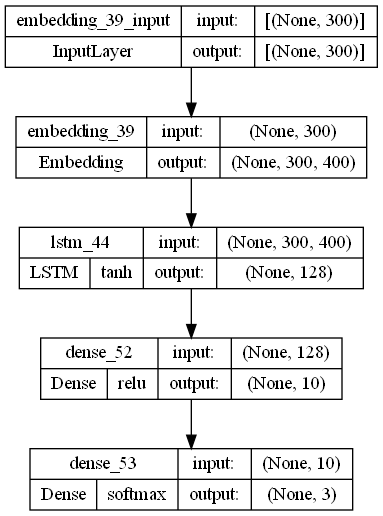

In [161]:
tf.keras.utils.plot_model(model_LSTM, to_file='model_LSTM.png', show_shapes=True, show_layer_activations=True)

In [164]:
score = model_LSTM.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_LSTM.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_LSTM.metrics_names[1], score[1]*100))

486/486 [==============================] - 96s 197ms/step - loss: 2.4346 - acc: 0.8265
loss: 2.43
acc: 82.65%


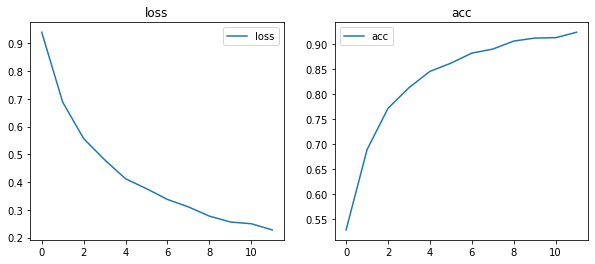

In [46]:
def plot_loss_accuracy(history):
    fig, axs = plt.subplots(1,2, figsize = (10, 4))
    hist = history.history
    for ax, metric in zip(axs, ["loss", "acc"]):
        ax.plot(hist[metric])
        ax.legend([metric])
        ax.set_title(metric)
    plt.style.use('default')
    
plot_loss_accuracy(history)

In [185]:
prediction = model_LSTM.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=1
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 0s 99ms/step
Vấn đề lớn nhất là nó dày quá a~ to, không thon gọn tinh tế như những mẫu khác, màu trắng nữa, dễ dơ. Còn lại thì okie nha.
Tích cực
Bình thường


In [195]:
preds = model_LSTM.predict(data_test)


486/486 [==============================] - 107s 220ms/step


In [196]:
test_class = np.argmax(labels_test, axis = 1)
preds_class = np.argmax(preds, axis = 1)


In [198]:
f1_score(test_class, preds_class, average=None)

array([0.62747909, 0.2400984 , 0.85606724])

## LSTM Attention

In [254]:
sequence_length = sub_data.shape[1]
drop = 0.1

inputs = Input(shape = (sequence_length,))
embedding = Embedding(vocabulary_size, EMBEDDING_DIM, weights = [embedding_matrix])(inputs)
bilstm = LSTM(128, return_sequences = True)(embedding)
attention_layer = attention()(bilstm)
output = Dense(units = 3, activation = 'softmax')(attention_layer)

model_lstm_att = Model(inputs, output)

In [255]:
# Retrieve the config
config = model_lstm_att.get_config()

# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"attention": attention}
with keras.utils.custom_object_scope(custom_objects):
    model_lstm_att = keras.Model.from_config(config)
    
model_lstm_att.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

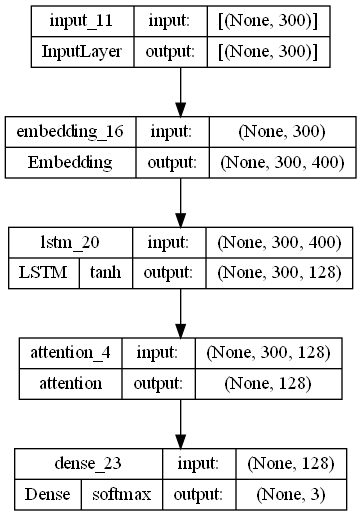

In [257]:
tf.keras.utils.plot_model(model_lstm_att, to_file='model_lstm_att.png', show_shapes=True, show_layer_activations=True)

In [258]:
%%time
model_lstm_att.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 172s 5s/step - loss: 1.0972 - acc: 0.3598 - val_loss: 1.0944 - val_acc: 0.5125
Epoch 2/100
36/36 [==============================] - 174s 5s/step - loss: 1.0061 - acc: 0.4914 - val_loss: 0.8570 - val_acc: 0.7064
Epoch 3/100
36/36 [==============================] - 191s 5s/step - loss: 0.8375 - acc: 0.6138 - val_loss: 0.6873 - val_acc: 0.7911
Epoch 4/100
36/36 [==============================] - 184s 5s/step - loss: 0.7237 - acc: 0.6800 - val_loss: 0.6855 - val_acc: 0.7815
Epoch 5/100
36/36 [==============================] - 183s 5s/step - loss: 0.6274 - acc: 0.7456 - val_loss: 0.7643 - val_acc: 0.7764
Epoch 6/100
36/36 [==============================] - 149s 4s/step - loss: 0.5591 - acc: 0.7842 - val_loss: 0.6757 - val_acc: 0.7672
Epoch 7/100
36/36 [==============================] - 148s 4s/step - loss: 0.5055 - acc: 0.8077 - val_loss: 0.6282 - val_acc: 0.8160
Epoch 8/100
36/36 [==============================] - 147s 4s/step - loss: 0.

In [261]:
score = model_lstm_att.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_lstm_att.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_lstm_att.metrics_names[1], score[1]*100))

486/486 [==============================] - 70s 144ms/step - loss: 0.9007 - acc: 0.7849
loss: 0.90
acc: 78.49%


In [262]:
prediction = model_lstm_att.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 1s 924ms/step
Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tiêu cực


In [263]:
preds = model_lstm_att.predict(data_test)
preds_class = np.argmax(preds, axis = 1)
f1_score(test_class, preds_class, average=None)

486/486 [==============================] - 68s 139ms/step


array([0.64424514, 0.28298172, 0.88476089])

## Bi-LSTM

In [187]:
model_Bi_LSTM = Sequential()
model_Bi_LSTM.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_Bi_LSTM.add(Bidirectional(LSTM(128, dropout = 0.1, return_sequences = False)))
model_Bi_LSTM.add(Dense(64, activation='relu'))
model_Bi_LSTM.add(Dense(3, activation='sigmoid'))
model_Bi_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [188]:
model_Bi_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 400)          4000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              541696    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 4,558,339
Trainable params: 4,558,339
Non-trainable params: 0
_________________________________________________________________


In [199]:
%%time
history = model_Bi_LSTM.fit(data, labels, epochs=100, batch_size=256, callbacks=callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 335s 9s/step - loss: 0.8399 - acc: 0.5850 - val_loss: 0.5543 - val_acc: 0.7998
Epoch 2/100
36/36 [==============================] - 330s 9s/step - loss: 0.5923 - acc: 0.7459 - val_loss: 0.5317 - val_acc: 0.8037
Epoch 3/100
36/36 [==============================] - 340s 9s/step - loss: 0.4601 - acc: 0.8170 - val_loss: 0.5849 - val_acc: 0.7870
Epoch 4/100
36/36 [==============================] - 343s 10s/step - loss: 0.3772 - acc: 0.8556 - val_loss: 0.6343 - val_acc: 0.7756
Epoch 5/100
36/36 [==============================] - 348s 10s/step - loss: 0.3178 - acc: 0.8850 - val_loss: 0.7194 - val_acc: 0.7669
Epoch 6/100
36/36 [==============================] - 350s 10s/step - loss: 0.2761 - acc: 0.9024 - val_loss: 0.7456 - val_acc: 0.7733
Epoch 7/100
36/36 [==============================] - 420s 12s/step - loss: 0.2515 - acc: 0.9100 - val_loss: 0.7639 - val_acc: 0.7714
Epoch 8/100
36/36 [==============================] - 436s 12s/step - los

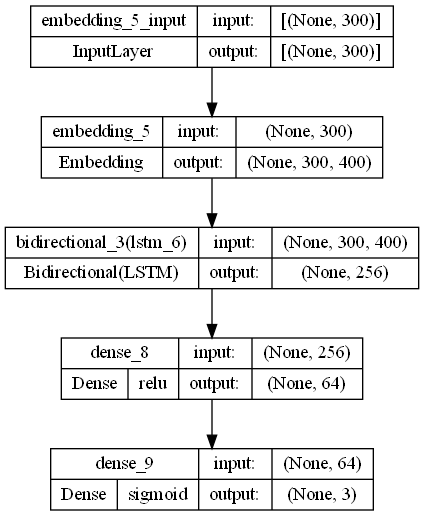

In [190]:
tf.keras.utils.plot_model(model_Bi_LSTM, to_file='model_Bi_LSTM.png', show_shapes=True, show_layer_activations=True)

In [200]:
score = model_Bi_LSTM.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_Bi_LSTM.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_Bi_LSTM.metrics_names[1], score[1]*100))

486/486 [==============================] - 385s 792ms/step - loss: 1.1715 - acc: 0.7198
loss: 1.17
acc: 71.98%


In [201]:
preds = model_Bi_LSTM.predict(data_test)
preds_class = np.argmax(preds, axis = 1)
f1_score(test_class, preds_class, average=None)

486/486 [==============================] - 303s 619ms/step


array([0.61026226, 0.23172988, 0.83547018])

## Bi LSTM Attention

In [220]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [221]:
sequence_length = sub_data.shape[1]
drop = 0.1

inputs = Input(shape = (sequence_length,))
embedding = Embedding(vocabulary_size, EMBEDDING_DIM, weights = [embedding_matrix])(inputs)
bilstm = Bidirectional(LSTM(128, return_sequences = True))(embedding)
attention_layer = attention()(bilstm)
output = Dense(units = 3, activation = 'softmax')(attention_layer)

model_bi_lstm_att = Model(inputs, output)

In [222]:
# Retrieve the config
config = model_bi_lstm_att.get_config()

# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"attention": attention}
with keras.utils.custom_object_scope(custom_objects):
    new_model_bi_lstm_att = keras.Model.from_config(config)
    
new_model_bi_lstm_att.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

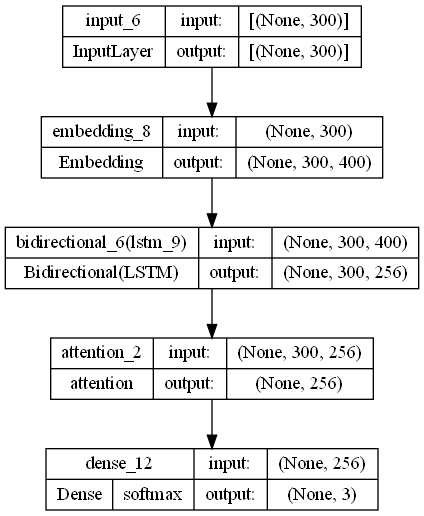

In [223]:
tf.keras.utils.plot_model(new_model_bi_lstm_att, to_file='model_bi_lstm_att.png', show_shapes=True, show_layer_activations=True)

In [224]:
%%time
new_model_bi_lstm_att.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 326s 9s/step - loss: 1.0886 - acc: 0.3762 - val_loss: 0.8060 - val_acc: 0.8003
Epoch 2/100
36/36 [==============================] - 326s 9s/step - loss: 0.9792 - acc: 0.5051 - val_loss: 0.8456 - val_acc: 0.7323
Epoch 3/100
36/36 [==============================] - 353s 10s/step - loss: 0.7933 - acc: 0.6330 - val_loss: 0.5841 - val_acc: 0.7884
Epoch 4/100
36/36 [==============================] - 397s 11s/step - loss: 0.6704 - acc: 0.7079 - val_loss: 0.6305 - val_acc: 0.7474
Epoch 5/100
36/36 [==============================] - 371s 10s/step - loss: 0.5763 - acc: 0.7678 - val_loss: 0.6740 - val_acc: 0.7479
Epoch 6/100
36/36 [==============================] - 372s 10s/step - loss: 0.5015 - acc: 0.8089 - val_loss: 0.6256 - val_acc: 0.7698
Epoch 7/100
36/36 [==============================] - 417s 12s/step - loss: 0.4519 - acc: 0.8337 - val_loss: 0.6790 - val_acc: 0.7625
Epoch 8/100
36/36 [==============================] - 400s 11s/step - lo

In [226]:
score = new_model_bi_lstm_att.evaluate(data_test, labels_test)

print("%s: %.2f" %(new_model_bi_lstm_att.metrics_names[0], score[0]))
print("%s: %.2f%%" %(new_model_bi_lstm_att.metrics_names[1], score[1]*100))

486/486 [==============================] - 201s 412ms/step - loss: 0.7839 - acc: 0.7757
loss: 0.78
acc: 77.57%


In [227]:
prediction = new_model_bi_lstm_att.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 2s 2s/step
Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tích cực


In [228]:
preds = new_model_bi_lstm_att.predict(data_test)
preds_class = np.argmax(preds, axis = 1)
f1_score(test_class, preds_class, average=None)

486/486 [==============================] - 212s 436ms/step


array([0.64355135, 0.27173913, 0.8803313 ])

## CNN

In [229]:

model_CNN = Sequential()
model_CNN.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_CNN.add(Dropout(0.1))
model_CNN.add(Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"))
model_CNN.add(MaxPooling1D())
model_CNN.add(Dropout(0.1))
model_CNN.add(Flatten())
model_CNN.add(Dense(units = 3, activation = 'softmax'))

model_CNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_CNN. summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 300, 400)          4000000   
                                                                 
 dropout_4 (Dropout)         (None, 300, 400)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 300, 32)           38432     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 150, 32)          0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 150, 32)           0         
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                      

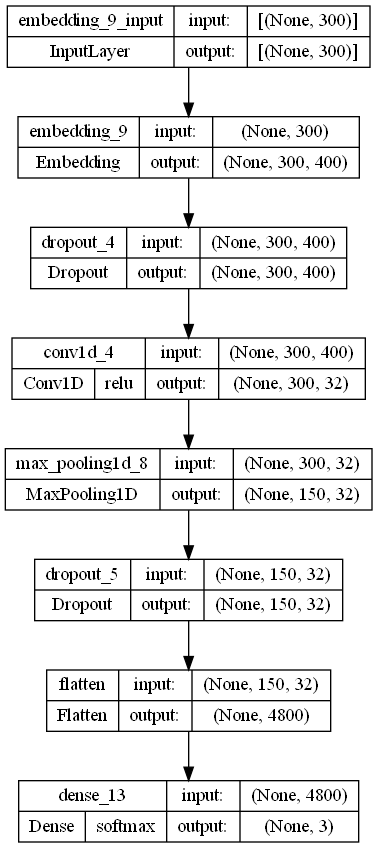

In [230]:
tf.keras.utils.plot_model(model_CNN, to_file='model_CNN.png', show_shapes=True, show_layer_activations=True)

In [231]:
%%time
model_CNN.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 39s 1s/step - loss: 1.0435 - accuracy: 0.4386 - val_loss: 0.7957 - val_accuracy: 0.7430
Epoch 2/100
36/36 [==============================] - 37s 1s/step - loss: 0.8056 - accuracy: 0.6240 - val_loss: 0.7928 - val_accuracy: 0.7404
Epoch 3/100
36/36 [==============================] - 37s 1s/step - loss: 0.6362 - accuracy: 0.7262 - val_loss: 0.6583 - val_accuracy: 0.7660
Epoch 4/100
36/36 [==============================] - 40s 1s/step - loss: 0.5097 - accuracy: 0.8004 - val_loss: 0.6086 - val_accuracy: 0.7844
Epoch 5/100
36/36 [==============================] - 44s 1s/step - loss: 0.4121 - accuracy: 0.8514 - val_loss: 0.6604 - val_accuracy: 0.7740
Epoch 6/100
36/36 [==============================] - 37s 1s/step - loss: 0.3378 - accuracy: 0.8807 - val_loss: 0.7459 - val_accuracy: 0.7619
Epoch 7/100
36/36 [==============================] - 38s 1s/step - loss: 0.2765 - accuracy: 0.9076 - val_loss: 0.5907 - val_accuracy: 0.8111
Epoch 8/100
3

In [232]:
score = model_CNN.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_CNN.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_CNN.metrics_names[1], score[1]*100))

486/486 [==============================] - 10s 21ms/step - loss: 1.0872 - accuracy: 0.7508
loss: 1.09
accuracy: 75.08%


In [233]:
prediction = model_CNN.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 0s 349ms/step
Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tích cực


In [234]:
preds = model_CNN.predict(data_test)
preds_class = np.argmax(preds, axis = 1)
f1_score(test_class, preds_class, average=None)

486/486 [==============================] - 13s 26ms/step


array([0.62978072, 0.2531767 , 0.86161471])

## CNN valid padding

In [112]:

model_CNN_valid = Sequential()
model_CNN_valid.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_CNN_valid.add(Dropout(0.1))
model_CNN_valid.add(Conv1D(filters=32, kernel_size=3, padding="valid", activation="relu"))
model_CNN_valid.add(MaxPooling1D())
model_CNN_valid.add(Dropout(0.1))
model_CNN_valid.add(Flatten())
model_CNN_valid.add(Dense(units = 3, activation = 'softmax'))

model_CNN_valid.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [113]:
%%time
model_CNN_valid.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 35s 943ms/step - loss: 1.0596 - accuracy: 0.4272 - val_loss: 0.8884 - val_accuracy: 0.7389
Epoch 2/100
36/36 [==============================] - 32s 897ms/step - loss: 0.8440 - accuracy: 0.6039 - val_loss: 0.5586 - val_accuracy: 0.8108
Epoch 3/100
36/36 [==============================] - 32s 882ms/step - loss: 0.6619 - accuracy: 0.7069 - val_loss: 0.6597 - val_accuracy: 0.7650
Epoch 4/100
36/36 [==============================] - 32s 880ms/step - loss: 0.5316 - accuracy: 0.7838 - val_loss: 0.5935 - val_accuracy: 0.7969
Epoch 5/100
36/36 [==============================] - 33s 910ms/step - loss: 0.4271 - accuracy: 0.8417 - val_loss: 0.6381 - val_accuracy: 0.7922
Epoch 6/100
36/36 [==============================] - 32s 887ms/step - loss: 0.3505 - accuracy: 0.8750 - val_loss: 0.6835 - val_accuracy: 0.7706
Epoch 7/100
36/36 [==============================] - 33s 929ms/step - loss: 0.2804 - accuracy: 0.9069 - val_loss: 0.6622 - val_accuracy:

In [114]:
score = model_CNN_valid.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_CNN_valid.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_CNN_valid.metrics_names[1], score[1]*100))

486/486 [==============================] - 6s 12ms/step - loss: 1.0723 - accuracy: 0.7428
loss: 1.07
accuracy: 74.28%


## CNN causal padding

In [115]:

model_CNN_causal = Sequential()
model_CNN_causal.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_CNN_causal.add(Dropout(0.1))
model_CNN_causal.add(Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu"))
model_CNN_causal.add(MaxPooling1D())
model_CNN_causal.add(Dropout(0.1))
model_CNN_causal.add(Flatten())
model_CNN_causal.add(Dense(units = 3, activation = 'softmax'))

model_CNN_causal.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [116]:
%%time
model_CNN_causal.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 39s 1s/step - loss: 1.0494 - accuracy: 0.4298 - val_loss: 0.8947 - val_accuracy: 0.7313
Epoch 2/100
36/36 [==============================] - 38s 1s/step - loss: 0.8289 - accuracy: 0.6058 - val_loss: 0.7049 - val_accuracy: 0.7749
Epoch 3/100
36/36 [==============================] - 38s 1s/step - loss: 0.6474 - accuracy: 0.7218 - val_loss: 0.5449 - val_accuracy: 0.8055
Epoch 4/100
36/36 [==============================] - 38s 1s/step - loss: 0.5168 - accuracy: 0.7936 - val_loss: 0.5920 - val_accuracy: 0.7874
Epoch 5/100
36/36 [==============================] - 38s 1s/step - loss: 0.4219 - accuracy: 0.8393 - val_loss: 0.5739 - val_accuracy: 0.8070
Epoch 6/100
36/36 [==============================] - 38s 1s/step - loss: 0.3426 - accuracy: 0.8756 - val_loss: 0.6687 - val_accuracy: 0.7843
Epoch 7/100
36/36 [==============================] - 38s 1s/step - loss: 0.2859 - accuracy: 0.9027 - val_loss: 0.7287 - val_accuracy: 0.7758
Epoch 8/100
3

In [117]:
score = model_CNN_causal.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_CNN_causal.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_CNN_causal.metrics_names[1], score[1]*100))

486/486 [==============================] - 8s 17ms/step - loss: 1.0106 - accuracy: 0.7494
loss: 1.01
accuracy: 74.94%


## CNN + LSTM tuần tự

In [237]:
model_CNN_LSTM = Sequential()
model_CNN_LSTM.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_CNN_LSTM.add(Dropout(0.1))
model_CNN_LSTM.add(Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"))
model_CNN_LSTM.add(MaxPooling1D())
model_CNN_LSTM.add(Dropout(0.1))
model_CNN_LSTM.add(LSTM(units=32,  dropout=drop, return_sequences = True))
model_CNN_LSTM.add(Flatten())
model_CNN_LSTM.add(Dense(units = 3, activation = 'softmax'))

adam = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
model_CNN_LSTM.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model_CNN_LSTM. summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 300, 400)          4000000   
                                                                 
 dropout_11 (Dropout)        (None, 300, 400)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 300, 32)           38432     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 150, 32)          0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 150, 32)           0         
                                                                 
 lstm_14 (LSTM)              (None, 150, 32)           8320      
                                                      

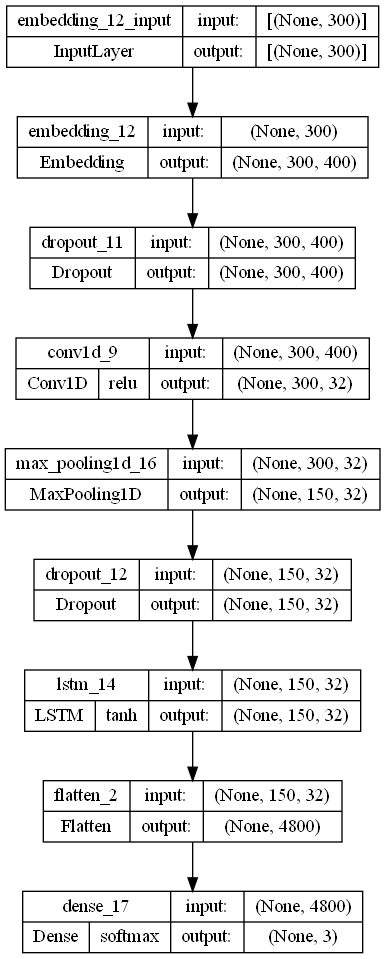

In [238]:
tf.keras.utils.plot_model(model_CNN_LSTM, to_file='model_CNN_LSTM.png', show_shapes=True, show_layer_activations=True)

In [239]:
%%time
model_CNN_LSTM.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 70s 2s/step - loss: 1.0436 - accuracy: 0.4358 - val_loss: 0.7589 - val_accuracy: 0.8157
Epoch 2/100
36/36 [==============================] - 58s 2s/step - loss: 0.7926 - accuracy: 0.6327 - val_loss: 0.5640 - val_accuracy: 0.8203
Epoch 3/100
36/36 [==============================] - 56s 2s/step - loss: 0.6408 - accuracy: 0.7257 - val_loss: 0.5402 - val_accuracy: 0.8136
Epoch 4/100
36/36 [==============================] - 54s 2s/step - loss: 0.5511 - accuracy: 0.7744 - val_loss: 0.6983 - val_accuracy: 0.7818
Epoch 5/100
36/36 [==============================] - 55s 2s/step - loss: 0.4766 - accuracy: 0.8158 - val_loss: 0.6709 - val_accuracy: 0.7828
Epoch 6/100
36/36 [==============================] - 54s 2s/step - loss: 0.4056 - accuracy: 0.8484 - val_loss: 0.8498 - val_accuracy: 0.7628
Epoch 7/100
36/36 [==============================] - 54s 2s/step - loss: 0.3495 - accuracy: 0.8716 - val_loss: 0.7588 - val_accuracy: 0.7880
Epoch 8/100
3

In [240]:
score = model_CNN_LSTM.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_CNN_LSTM.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_CNN_LSTM.metrics_names[1], score[1]*100))

486/486 [==============================] - 16s 33ms/step - loss: 1.3463 - accuracy: 0.7340
loss: 1.35
accuracy: 73.40%


In [241]:
prediction = model_CNN_LSTM.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 1s 766ms/step
Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tiêu cực


In [242]:
preds = model_CNN_LSTM.predict(data_test)
preds_class = np.argmax(preds, axis = 1)
f1_score(test_class, preds_class, average=None)

486/486 [==============================] - 132s 271ms/step


array([0.64974874, 0.24558304, 0.84680776])